# Parallelise openscm-runner

- 2237 ensemble members x 1600 scenarios is going to take a long time, even at 12 runs/second.

Theme Song: All The Small Things<br>
Artist: Blink-182<br>
Album: Enema of the State<br>
Released: 2000

In [1]:
import os.path

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyam
from fair.forward import fair_scm
from scmdata import ScmRun, run_append
from tqdm import tqdm_notebook

import openscm_runner
from openscm_runner.run import run
from openscm_runner.adapters import FAIR

<IPython.core.display.Javascript object>

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_runner/progress.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
openscm_runner.__version__

'0.1.0-alpha.1+309.g0ab51a4'

In [3]:
fair = FAIR()
fair.get_version()

'1.6.2'

In [4]:
with open('../data_output_large/fair-samples/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [5]:
species = [
'Emissions|BC',
'Emissions|CH4',
'Emissions|CO',
'Emissions|CO2|MAGICC AFOLU',
'Emissions|CO2|MAGICC Fossil and Industrial',
'Emissions|F-Gases|HFC|HFC125',
'Emissions|F-Gases|HFC|HFC134a',
'Emissions|F-Gases|HFC|HFC143a',
'Emissions|F-Gases|HFC|HFC227ea',
'Emissions|F-Gases|HFC|HFC23',
'Emissions|F-Gases|HFC|HFC245fa',
'Emissions|F-Gases|HFC|HFC32',
'Emissions|F-Gases|HFC|HFC4310mee',
'Emissions|F-Gases|PFC|C2F6',
'Emissions|F-Gases|PFC|C6F14',
'Emissions|F-Gases|PFC|CF4',
'Emissions|F-Gases|SF6',
'Emissions|Montreal Gases|CCl4',
'Emissions|Montreal Gases|CFC|CFC11',
'Emissions|Montreal Gases|CFC|CFC113',
'Emissions|Montreal Gases|CFC|CFC114',
'Emissions|Montreal Gases|CFC|CFC115',
'Emissions|Montreal Gases|CFC|CFC12',
'Emissions|Montreal Gases|CH3Br',
'Emissions|Montreal Gases|CH3CCl3',
'Emissions|Montreal Gases|CH3Cl',
'Emissions|Montreal Gases|HCFC141b',
'Emissions|Montreal Gases|HCFC142b',
'Emissions|Montreal Gases|HCFC22',
'Emissions|Montreal Gases|Halon1202',
'Emissions|Montreal Gases|Halon1211',
'Emissions|Montreal Gases|Halon1301',
'Emissions|Montreal Gases|Halon2402',
'Emissions|N2O',
'Emissions|NH3',
'Emissions|NOx',
'Emissions|OC',
'Emissions|Sulfur',
'Emissions|VOC']

In [6]:
df_fair = ScmRun('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv', lowercase_cols=True)
df_fair.filter(
    scenario=['ssp119','ssp126','ssp245','ssp370','ssp434','ssp460','ssp534-over','ssp585'], 
    year=range(2015,2101),
    variable=species,
    region='World', 
    inplace=True
)
print(len(df_fair))

312


In [7]:
nt = df_fair.time_points.years()[-1] - 1750 + 1
nt

351

In [8]:
# convert lists to numpy arrays
updated_config = []
for i in range(len(config_list)):
    updated_config.append({})
    for key, value in config_list[i].items():
        if type(value)==list:
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value

In [9]:
len(updated_config)

2237

In [10]:
# need parallel FaIR in openscm-runner

x = run(
    climate_models_cfgs={
        "FAIR": updated_config,
    },
    scenarios=df_fair,
    output_variables=(
        "Surface Air Temperature Change",
        "Surface Air Ocean Blended Temperature Change",
        "Effective Radiative Forcing",
        "Effective Radiative Forcing|Volcanic",
        "Effective Radiative Forcing|Solar",
        "Effective Radiative Forcing|Anthropogenic",
    ),
)

Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Creating FaIR emissions inputs:   0%|          | 0.00/8.00 [00:00<?, ?it/s]

In [11]:
# convert to ScmRun for better plotting functionality
x = ScmRun(x.timeseries())

In [12]:
x.tail()

time                                                                                                    1750-01-01  \
climate_model model         region run_id scenario unit   variable                                                   
FaIRv1.6.2    REMIND-MAGPIE World  17895  ssp585   K      Surface Air Ocean Blended Temperature Change    0.028903   
                                                   W/m**2 Effective Radiative Forcing                     0.322464   
                                                          Effective Radiative Forcing|Volcanic            0.227682   
                                                          Effective Radiative Forcing|Solar               0.094167   
                                                          Effective Radiative Forcing|Anthropogenic       0.000677   

time                                                                                                    1751-01-01  \
climate_model model         region run_id scenario unit   variable                                                   
FaIRv1.6.2    REMIND-MAGPIE World  17895  ssp585   K      Surface Air Ocean Blended Temperature Change    0.050731   
                                                   W/m**2 Effective Radiative Forcing                     0.278080   
                                                          Effective Radiative Forcing|Volcanic            0.227696   
                                                          Effective Radiative Forcing|Solar               0.076511   
                                                          Effective Radiative Forcing|Anthropogenic      -0.029470   

time                                                                                                    1752-01-01  \
climate_model model         region run_id scenario unit   variable                                                   
FaIRv1.6.2    REMIND-MAGPIE World  17895  ssp585   K      Surface Air Ocean Blended Temperature Change    0.065179   
                                                   W/m**2 Effective Radiative Forcing                     0.241880   
                                                          Effective Radiative Forcing|Volcanic            0.227700   
                                                          Effective Radiative Forcing|Solar               0.047536   
                                                          Effective Radiative Forcing|Anthropogenic      -0.038743   

time                                                                                                    1753-01-01  \
climate_model model         region run_id scenario unit   variable                                                   
FaIRv1.6.2    REMIND-MAGPIE World  17895  ssp585   K      Surface Air Ocean Blended Temperature Change    0.073775   
                                                   W/m**2 Effective Radiative Forcing                     0.203167   
                                                          Effective Radiative Forcing|Volcanic            0.227702   
                                                          Effective Radiative Forcing|Solar               0.012675   
                                                          Effective Radiative Forcing|Anthropogenic      -0.040492   

time                                                                                                    1754-01-01  \
climate_model model         region run_id scenario unit   variable                                                   
FaIRv1.6.2    REMIND-MAGPIE World  17895  ssp585   K      Surface Air Ocean Blended Temperature Change    0.077560   
                                                   W/m**2 Effective Radiative Forcing                     0.167197   
                                                          Effective Radiative Forcing|Volcanic            0.227702   
                                                          Effective Radiative Forcing|Solar           

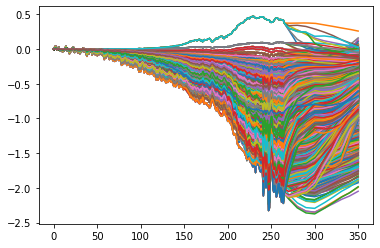

In [13]:
anthro = x.filter(variable='Effective Radiative Forcing|Anthropogenic').values.T
solar = x.filter(variable='Effective Radiative Forcing|Solar').values.T
volcanic = x.filter(variable='Effective Radiative Forcing|Volcanic').values.T
total = x.filter(variable='Effective Radiative Forcing').values.T
plt.plot(total-solar-volcanic-anthro); # should be zero

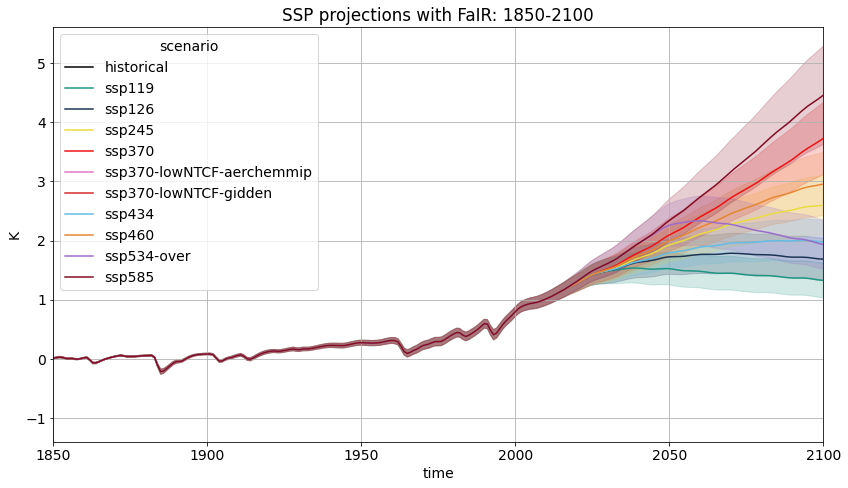

In [14]:
from scmdata.plotting import RCMIP_SCENARIO_COLOURS

plt.rcParams['font.size'] = 14
ax = plt.figure(figsize=(12, 7)).add_subplot(111)

x.filter(variable="Surface Air Temperature Change").relative_to_ref_period_mean(year=range(1850,1900)).lineplot(
    hue="scenario",
    ax=ax,
    time_axis="year",
    palette=RCMIP_SCENARIO_COLOURS,
    hue_order=RCMIP_SCENARIO_COLOURS.keys(),
)
ax.set_xlim(1850,2100)
#ax.axhline(0, color='k', ls=':')
ax.grid()
ax.set_title('SSP projections with FaIR: 1850-2100')
plt.tight_layout()